In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os,time
import cv2
import skimage

from skimage.exposure import cumulative_distribution
from skimage.morphology import opening, square
from skimage import img_as_ubyte

from PIL import Image
from scipy.stats import t,norm
from google.colab.patches import cv2_imshow

!pip install scikit-optimize
from skopt import gp_minimize
from skopt.utils import use_named_args
from skopt.space import Real, Categorical, Integer

     |████████████████████████████████| 81kB 3.7MB/s 


In [0]:
#Put the file gt in good shape

cols = ['img','x1','y1','x2','y2','class']
gt = pd.read_table('/content/gt.txt', sep=';', header=None)
gt.columns = cols
gt.drop(columns=['class'],inplace=True)
gt["img"] = gt["img"].astype('category')
gt["img"] = gt["img"].cat.codes
gt.head()

,img,x1,y1,x2,y2
0,0,774,411,815,446
1,1,983,388,1024,432
2,1,386,494,442,552
3,1,973,335,1031,390
4,2,892,476,1006,592


In [0]:
#Load the dataset
img_set=[]
files = os.listdir("/content/drive/My Drive/vic/FullIJCNN2013")
for file in files:
  img_set.append(Image.open("/content/drive/My Drive/vic/FullIJCNN2013/"+file))

In [0]:
#   Red-Blue normalization 

def transformed(img_brute):  
  img_brute=np.array(img_brute)
  X,Y,Z=img_brute.shape
  im_sum = np.sum(img_brute, axis = 2)
  red = np.divide(img_brute[:,:,0],im_sum)
  blue = np.divide(img_brute[:,:,2],im_sum)
  normalized = np.maximum(red,blue)
  normalized = np.int64(normalized*255)
  return normalized

In [0]:
#   Thresholding the image w.r.t two method :
#     Classic: proposed by the article
#     Transformed: proposed by oureselves (much more white points)
def thresholding(img_brute, quantile, method='Classic'):
  trans_ = transformed(img_brute)
  tresh =  np.quantile(trans_, quantile)
  if method == 'Classic':

    #The coefficient proposed by the article 
    coef = (trans_ - tresh)/(np.amax(trans_) - tresh)
    im_thresh = (trans_ == tresh)*255 + (trans_ < tresh)*0 + (trans_ > tresh)*coef*255
  else: 
    im_thresh = (trans_ >= tresh)*255 + (trans_ < tresh)*0 

  return im_thresh.astype(int)

In [0]:
def morphological(img):
  return opening(img,square(2))

In [0]:
def non_max_suppression_fast(boxes, coords, overlapThresh):
	# if there are no boxes, return an empty list
	if len(boxes) == 0:
		return []
	# if the bounding boxes integers, convert them to floats --
	# this is important since we'll be doing a bunch of divisions
	if boxes.dtype.kind == "i":
		boxes = boxes.astype("float")
	# initialize the list of picked indexes	
	pick = []
	# grab the coordinates of the bounding boxes
	x1 = boxes[:,0]
	y1 = boxes[:,1]
	x2 = boxes[:,2]+boxes[:,0]
	y2 = boxes[:,3]+boxes[:,1]
	# compute the area of the bounding boxes and sort the bounding
	# boxes by the bottom-right y-coordinate of the bounding box
	area = (x2 - x1 + 1) * (y2 - y1 + 1)
	idxs = np.argsort(y2)
	# keep looping while some indexes still remain in the indexes
	# list
	while len(idxs) > 0:
		# grab the last index in the indexes list and add the
		# index value to the list of picked indexes
		last = len(idxs) - 1
		i = idxs[last]
		pick.append(i)
		# find the largest (x, y) coordinates for the start of
		# the bounding box and the smallest (x, y) coordinates
		# for the end of the bounding box
		xx1 = np.maximum(x1[i], x1[idxs[:last]])
		yy1 = np.maximum(y1[i], y1[idxs[:last]])
		xx2 = np.minimum(x2[i], x2[idxs[:last]])
		yy2 = np.minimum(y2[i], y2[idxs[:last]])
		# compute the width and height of the bounding box
		w = np.maximum(0, xx2 - xx1 + 1)
		h = np.maximum(0, yy2 - yy1 + 1)
		# compute the ratio of overlap
		overlap = (w * h) / area[idxs[:last]]
		# delete all indexes from the index list that have
		idxs = np.delete(idxs, np.concatenate(([last],
			np.where(overlap > overlapThresh)[0])))
	# return only the bounding boxes that were picked using the
	# integer data type
	return boxes[pick].astype("int"), list(np.array(coords)[pick])

In [0]:
#   MSER + Non maximum suppression 
#   This function returns bboxes of the supposed traffic signs
def MSER_algo(img_brute,delta=2, quantile=0.9, method='Classic',overlapThresh=0.1):
  # Previous filters
  im_step3 = img_as_ubyte(morphological(thresholding(img_brute,quantile,method))/255)

  mser = cv2.MSER_create()
  mser.setDelta(delta)

  coords, bboxes = mser.detectRegions(im_step3)

  ##Non maximum suppression
  bboxes, coords = non_max_suppression_fast(bboxes, coords, overlapThresh)
  hulls = [cv2.convexHull(p.reshape(-1, 1, 2)) for p in coords]
  coords_bis = [[list(hulls[j][i][0]) for i in range(len(hulls[j]))] for j in range(len(hulls))]
  coords_bis = [np.array(coords_bis[k]) for k in range(len(coords_bis))]

  return bboxes, coords_bis

In [0]:
#   Remove the non symetric elements
def symetry(img, bboxes, contours , mu0 = 50, alpha = 0.05):
  indices=[]
  eps=1e-10
  for i in range(len(bboxes)) :
    x, y, w, h = bboxes[i]
    mask = np.zeros_like(img)
    contour = contours[i]
    xx = contour[:,0]
    yy = contour[:,1]
    mask[yy, xx] = 255
    box_mask=mask[y:y+h,x:x+w]
    C=[]
    N=box_mask.shape[1]
    for y in range(N):
      C.append(len(np.where(box_mask[:,y][:,0]==255)[0]))

    d=[min(np.abs(C[0]-C[-1]),np.abs(C[0]-C[-2]))]+[min(np.abs(C[i]-C[-(i+2)]),np.abs(C[i]-C[-(i+2)+1]),
                                                    np.abs(C[i]-C[-(i+2)+2])) for i in range(1,N//2)]
    n=len(d)
    d_mean=np.mean(d)
    S=np.sqrt(np.sum((d-d_mean)**2)/(n-1))
    z=np.sqrt(n)*(d_mean-mu0)/(S+eps)
    if n < 45 :
      quantile=t.ppf(1-alpha, n - 1)
    else :
      quantile=norm.ppf(1-alpha)
    if z>quantile :
      indices.append(i)
      #print("la forme est asymétrique")
    #else :
      #print("la forme est symétrique")
  return np.array([box for i,box in enumerate(bboxes) if i not in indices])

In [0]:
# Apply our geometrical constraints
def geometry(bboxes,w=[30,130],h=[30,130],h_w=[0.8,1.2],area=[144,16900]):
  resultat=[]
  for box in bboxes :
    xb,yb,wb,hb=box
    h_wb=hb/wb
    areab=wb*hb
    if (w[0]<=wb<=w[1]) and (h[0]<=hb<=h[1]) and (h_w[0]<=h_wb<=h_w[1]) and area[0]<=areab<=area[1]:
      resultat.append(box)
  return resultat

In [0]:
def evaluate_solution(gt, pred, img_set,indices):
    """Caclulate jaccard index"""
    #  param : 
    #  pred is an array of bboxes in format (x y w h)
    #  gt is a dataframe with cols = img: the img index, 
    #  and x1,y1,x2,y2 the bb coordinates in format DownRow, leftCols_

    score = [] #score for each image of our dataset
    #for each frame we take the bbox
    for frame_pred,frame_gt in enumerate(indices):
        bbs_gt = gt[gt['img']==frame_gt] #still a pandas df
        bbs_pred = pred[frame_pred] #array of shape nb of bbox*4

        #We need to find _W and _H
        black_sol = np.zeros_like(img_set[frame_gt])
        black_gt = np.zeros_like(img_set[frame_pred])

        #iterate over the rows of a pandas df
        for _, bb in bbs_gt.iterrows(): 
            idx, x1, y1, x2, y2 = bb
            cv2.rectangle(black_gt, (x1, y1), (x2, y2), (255), -1)
        for bb in bbs_pred:
            x, y, w, h = bb
            cv2.rectangle(black_sol, (x, y), (x + w, y + h), (255), -1)
        
        # intersection over union
        intersection = black_sol * black_gt
        intersection[intersection > 0.5] = 1
        union = black_sol + black_gt 
        union[union > 0.5] = 1
        if not union.any():
            continue
        score.append(intersection.sum()/union.sum())
    return np.asarray(score).mean(), score

In [0]:
def get_prediction(delta,quantile,method,overlapThresh,mu0,img_set_pred):
  pred = []
  i=0
  for im in img_set_pred:
      mser_bb, mser_coords = MSER_algo(im, delta=delta, quantile=quantile, method=method,overlapThresh=overlapThresh)
      bb_symet = symetry(im, mser_bb, mser_coords,mu0=mu0,alpha = 0.05)
      bb_final = geometry(bb_symet)
      pred.append(bb_final)
      i+=1
      if i%100==0:
        print(i)
  return np.array(pred)

In [0]:
time_start=time.perf_counter()
pred=get_prediction (delta=2,quantile=0.9,'Classic',method=0.1,overlapThresh=0.15,img_set_pred=img_set)
time_elapsed = (time.perf_counter() - time_start)
print ("Temps : %5.1f secs"  % (time_elapsed))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


100
200
300
400
500
600
700
800
900
Temps : 445.6 secs


In [0]:
score_mean,scores=evaluate_solution(gt,pred,img_set,range(len(img_set)))

In [0]:
print(score_mean,np.max(scores))

In [0]:
print(score_mean,np.max(scores))

0.0015503213802537227 0.17647058823529413


In [0]:
indices=np.array(scores).argsort()[-20:][::-1]
img_set_opt=[img_set[i] for i in indices]

In [0]:
[scores[i] for i in indices]

[0.17647058823529413,
 0.16714864083285136,
 0.1610305958132045,
 0.14346470087893393,
 0.06544836379090523,
 0.06514657980456026,
 0.05781739339918092,
 0.05595622979358369,
 0.051188151041666664,
 0.04816168565899807,
 0.04437806699381267,
 0.04115917681646367,
 0.03878748370273794,
 0.037160552644116246,
 0.030553787396562698,
 0.02566271855611957,
 0.021341797088759988,
 0.020879248347059506,
 0.018467995802728225,
 0.018188277087033747]

In [0]:
dim_delta=Integer(1,5,name="delta")
dim_quantile=Real(low=8.8e-1,high=9.5e-1,name="quantile")
dim_method=Categorical(['Classic','Transformed'],name="method")
dim_overlap=Real(0.01,0.8,name="overlap")
dim_mu0=Real(0.001,1.2,name="mu0")

dimensions=[dim_delta,
            dim_quantile,
            dim_method,
            dim_overlap,
            dim_mu0]

default_parameters = [2,0.9,'Classic',0.1,0.58]

In [0]:
@use_named_args(dimensions=dimensions)

def f_opt(delta,quantile,method,overlap,mu0):
  print(delta,quantile,method,overlap,mu0)
  pred=get_prediction(delta,quantile,method,overlap,mu0,img_set_opt)
  score_mean,scores=evaluate_solution(gt,pred,img_set,indices)
  return -score_mean

gp_result = gp_minimize(func=f_opt,
                        dimensions=dimensions,
                        acq_func="EI",
                        n_calls=50,
                        noise= "gaussian",
                        n_jobs=-1,
                        x0=default_parameters,
                        verbose=True)

Iteration No: 1 started. Evaluating function at provided point.
2 0.9 Classic 0.1 0.58


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 1 ended. Evaluation done at provided point.
Time taken: 10.4907
Function value obtained: -0.4690
Current minimum: -0.4690
Iteration No: 2 started. Evaluating function at random point.
4 0.9111486021130446 Classic 0.04444362799777523 0.35074794078879123
10
20
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 7.0954
Function value obtained: -0.5271
Current minimum: -0.5271
Iteration No: 3 started. Evaluating function at random point.
3 0.9018932827895533 Classic 0.4849703737980962 0.7042698550860911
10
20
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 8.1685
Function value obtained: -0.4737
Current minimum: -0.5271
Iteration No: 4 started. Evaluating function at random point.
2 0.8970251810506276 Classic 0.4430647160996547 0.4080621248465051
10
20
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 11.4971
Function value obtained: -0.4728
Current minimum: -0.5271
Iteration No: 5 started. Evaluating function at ran

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 9.8351
Function value obtained: -0.3969
Current minimum: -0.5271
Iteration No: 13 started. Searching for the next optimal point.
1 0.88 Transformed 0.6127625315680303 0.6202216392528677


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 17.3519
Function value obtained: -0.2514
Current minimum: -0.5271
Iteration No: 14 started. Searching for the next optimal point.
4 0.9332826731338942 Classic 0.1131674526553194 1.1987846330443024


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 6.8359
Function value obtained: -0.5224
Current minimum: -0.5271
Iteration No: 15 started. Searching for the next optimal point.
5 0.9215295938652085 Classic 0.01 0.8553046796657103


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 6.7624
Function value obtained: -0.5146
Current minimum: -0.5271
Iteration No: 16 started. Searching for the next optimal point.
4 0.9200729324433674 Classic 0.8 1.2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 7.2985
Function value obtained: -0.5477
Current minimum: -0.5477
Iteration No: 17 started. Searching for the next optimal point.
2 0.9180965582044653 Classic 0.4689897697534554 1.2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 10.4344
Function value obtained: -0.4490
Current minimum: -0.5477
Iteration No: 18 started. Searching for the next optimal point.
5 0.95 Classic 0.6960252242685622 0.8521038866495009


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 6.3125
Function value obtained: -0.5632
Current minimum: -0.5632
Iteration No: 19 started. Searching for the next optimal point.
5 0.95 Classic 0.8 0.001


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 6.4733
Function value obtained: -0.1460
Current minimum: -0.5632
Iteration No: 20 started. Searching for the next optimal point.
5 0.95 Classic 0.8 1.1724348322084255


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 6.4244
Function value obtained: -0.5632
Current minimum: -0.5632
Iteration No: 21 started. Searching for the next optimal point.
5 0.9384910329208499 Classic 0.8 1.0039177815451268


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 6.7344
Function value obtained: -0.5508
Current minimum: -0.5632
Iteration No: 22 started. Searching for the next optimal point.
5 0.9071117482057842 Classic 0.8 1.2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 6.9442
Function value obtained: -0.6303
Current minimum: -0.6303
Iteration No: 23 started. Searching for the next optimal point.
5 0.889345048493987 Classic 0.7872001884988099 1.2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 7.2219
Function value obtained: -0.5615
Current minimum: -0.6303
Iteration No: 24 started. Searching for the next optimal point.
1 0.95 Classic 0.7912814441909858 0.9626875017776236


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 10.5487
Function value obtained: -0.3939
Current minimum: -0.6303
Iteration No: 25 started. Searching for the next optimal point.
1 0.95 Transformed 0.22230435019804964 1.2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 9.4492
Function value obtained: -0.3924
Current minimum: -0.6303
Iteration No: 26 started. Searching for the next optimal point.
1 0.9129478819323559 Classic 0.1463119450915059 0.001


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 14.7901
Function value obtained: -0.1776
Current minimum: -0.6303
Iteration No: 27 started. Searching for the next optimal point.
5 0.9103780766350998 Classic 0.8 1.0739515029280096


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 6.9507
Function value obtained: -0.6192
Current minimum: -0.6303
Iteration No: 28 started. Searching for the next optimal point.
5 0.8976528683019593 Classic 0.4984887944900814 0.001


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 6.9927
Function value obtained: -0.1654
Current minimum: -0.6303
Iteration No: 29 started. Searching for the next optimal point.
3 0.948302441880271 Classic 0.5126657094382295 1.2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 7.1945
Function value obtained: -0.5190
Current minimum: -0.6303
Iteration No: 30 started. Searching for the next optimal point.
5 0.885976436360802 Classic 0.01 1.1037559960742391


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 7.1229
Function value obtained: -0.5124
Current minimum: -0.6303
Iteration No: 31 started. Searching for the next optimal point.
5 0.8915568062128443 Classic 0.8 1.0482377866463732


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 7.1976
Function value obtained: -0.5608
Current minimum: -0.6303
Iteration No: 32 started. Searching for the next optimal point.
5 0.9239338431190115 Transformed 0.07531079150976239 0.3887148530358126


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 12.3013
Function value obtained: -0.3666
Current minimum: -0.6303
Iteration No: 33 started. Searching for the next optimal point.
5 0.95 Classic 0.8 0.5802547663709936


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 6.6121
Function value obtained: -0.5632
Current minimum: -0.6303
Iteration No: 34 started. Searching for the next optimal point.
5 0.8825597067558643 Classic 0.8 0.27911567001467547


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 34 ended. Search finished for the next optimal point.
Time taken: 7.5231
Function value obtained: -0.5629
Current minimum: -0.6303
Iteration No: 35 started. Searching for the next optimal point.
5 0.88 Classic 0.8 0.6576044935445787


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 35 ended. Search finished for the next optimal point.
Time taken: 7.4954
Function value obtained: -0.5633
Current minimum: -0.6303
Iteration No: 36 started. Searching for the next optimal point.
5 0.9499575398130499 Transformed 0.8 1.2


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 36 ended. Search finished for the next optimal point.
Time taken: 9.6803
Function value obtained: -0.3924
Current minimum: -0.6303
Iteration No: 37 started. Searching for the next optimal point.
5 0.9304720161437205 Classic 0.8 0.4488858766009739


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 37 ended. Search finished for the next optimal point.
Time taken: 6.6739
Function value obtained: -0.5588
Current minimum: -0.6303
Iteration No: 38 started. Searching for the next optimal point.
5 0.9408432538230157 Classic 0.01 0.24659810879250152


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 38 ended. Search finished for the next optimal point.
Time taken: 6.4539
Function value obtained: -0.4922
Current minimum: -0.6303
Iteration No: 39 started. Searching for the next optimal point.
5 0.909912686408658 Classic 0.016128891142304532 0.6523247793721905


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 39 ended. Search finished for the next optimal point.
Time taken: 7.0329
Function value obtained: -0.5493
Current minimum: -0.6303
Iteration No: 40 started. Searching for the next optimal point.
5 0.8877852951122447 Classic 0.7926308922314469 0.34856341507614763


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 40 ended. Search finished for the next optimal point.
Time taken: 7.3235
Function value obtained: -0.5615
Current minimum: -0.6303
Iteration No: 41 started. Searching for the next optimal point.
5 0.9291383593997989 Classic 0.7992481049484198 0.7309394271524877


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 6.6832
Function value obtained: -0.5601
Current minimum: -0.6303
Iteration No: 42 started. Searching for the next optimal point.
5 0.9449752839803834 Classic 0.792507364351568 0.5403709006090877


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 6.4745
Function value obtained: -0.5627
Current minimum: -0.6303
Iteration No: 43 started. Searching for the next optimal point.
5 0.9394369103245598 Classic 0.05315727173200642 1.1991384661027253


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 6.5839
Function value obtained: -0.5163
Current minimum: -0.6303
Iteration No: 44 started. Searching for the next optimal point.
5 0.9024977943313479 Classic 0.012367098209510492 0.5239324430264208


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 6.9669
Function value obtained: -0.5605
Current minimum: -0.6303
Iteration No: 45 started. Searching for the next optimal point.
5 0.8940294598601155 Classic 0.7869738111835554 0.93872646044568


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 7.0734
Function value obtained: -0.5661
Current minimum: -0.6303
Iteration No: 46 started. Searching for the next optimal point.
5 0.9194003639247227 Classic 0.790434481530956 1.0997112424320485


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 46 ended. Search finished for the next optimal point.
Time taken: 6.7642
Function value obtained: -0.5646
Current minimum: -0.6303
Iteration No: 47 started. Searching for the next optimal point.
5 0.9377243357215546 Classic 0.7807555961823398 0.32059167047788306


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 47 ended. Search finished for the next optimal point.
Time taken: 6.7038
Function value obtained: -0.5520
Current minimum: -0.6303
Iteration No: 48 started. Searching for the next optimal point.
5 0.8877396160042357 Classic 0.780881615044455 0.6224219574522458


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 48 ended. Search finished for the next optimal point.
Time taken: 7.3987
Function value obtained: -0.5615
Current minimum: -0.6303
Iteration No: 49 started. Searching for the next optimal point.
5 0.9238322092659506 Classic 0.7846555151882674 1.196275356976746


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 49 ended. Search finished for the next optimal point.
Time taken: 6.9274
Function value obtained: -0.5615
Current minimum: -0.6303
Iteration No: 50 started. Searching for the next optimal point.
5 0.888626692705493 Classic 0.7879383491623382 0.2363682928249995


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


10
20
Iteration No: 50 ended. Search finished for the next optimal point.
Time taken: 7.3954
Function value obtained: -0.5615
Current minimum: -0.6303


In [0]:
gp_result.x

[5, 0.9071117482057842, 'Classic', 0.8, 1.2]

In [0]:
pred=get_prediction(5, 0.907, 'Classic', 0.8, 1.2,img_set_opt)
score_mean,scores=evaluate_solution(gt,pred,img_set,indices)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


In [0]:
print(score_mean)
print(scores)

0.6268148002877693
[0.8809542131589073, 0.8981036203611288, 0.8147773279352226, 0.6333853354134166, 0.5928063943161634, 0.9232129325587269, 0.6169302325581395, 0.897344278126509, 0.841248303934871, 0.588135112120352, 0.7444825895046592, 0.3247100802854594, 0.33834299178500926, 0.262643196423582, 0.2821109456440804, 0.850566037735849, 0.7256235827664399, 0.8762886597938144, 0.44463017133305477, 0.0]


To plot an example :

In [0]:
def plot_image_traffic_signs(img):
  pred=get_prediction(5, 0.91, 'Classic', 0.8, 1.2,[img])
  canvas1 = img.copy()
  canvas1 = np.uint8(canvas1)
  colors = [[43, 43, 200], [43, 75, 200], [43, 106, 200], [43, 137, 200], [43, 169, 200], [43, 200, 195], [43, 200, 163], [43, 200, 132], [43, 200, 101], [43, 200, 69], [54, 200, 43], [85, 200, 43], [116, 200, 43], [148, 200, 43], [179, 200, 43], [200, 184, 43], [200, 153, 43], [200, 122, 43], [200, 90, 43], [200, 59, 43], [200, 43, 64], [200, 43, 95], [200, 43, 127], [200, 43, 158], [200, 43, 190], [174, 43, 200], [142, 43, 200], [111, 43, 200], [80, 43, 200], [43, 43, 200]]
  for box in pred[0] :
    x, y, w, h = box
    color=colors[np.random.choice(len(colors))]
    cv2.rectangle(canvas1, (x, y), (x + w, y + h), color, 2)
  plt.imshow(canvas1,cmap="gray")
  plt.show()
  ## Save 
  plt.imsave("result.png", canvas1)

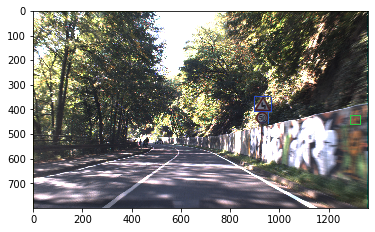

In [0]:
plot_image_traffic_signs(img_set[4])